In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve 
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.feature_selection import SelectKBest, chi2

Using Theano backend.


In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# Load the Data

In [3]:
df = pd.read_csv('us_census_full/census_income_learn.csv', header=None)
test = pd.read_csv('us_census_full/census_income_test.csv', header=None)

# Name the columns and investigate null values

Below is a function to name the columns in the DataFrame using the ReadMe.txt file

In [4]:
def name_columns(df, txt_file):
    '''Takes the desired DataFrame and metadata with the column names and
       returns the same DataFrame with the columns named.
       Inputs: Census DataFrame, metadata file
       Output: Census DataFrame with columns named.'''
    
    file = open(txt_file,"r",encoding='utf-8-sig') 
    text = file.read()
    
    desired_text = text.split('\n')[142:184]
    col_names = [line.split(':')[0] for line in desired_text]
    
    col_names.remove('| instance weight')
    col_names.append('target')
    df.columns = col_names
    
    return df

In [5]:
df = name_columns(df, 'us_census_full/census_income_metadata.txt')
test = name_columns(test, 'us_census_full/census_income_metadata.txt')

## Set below 50000 as 0 and above as 1

In [6]:
df.target.replace({'-50000': 0, ' 50000+.':1}, inplace=True)
test.target.replace({' - 50000.': 0, ' 50000+.':1}, inplace=True)

## Cast all 'objects' as 'categories'
This will improve performance and make the data types consistent later on if I decide to bin numerical data.

In [7]:
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
test[test.select_dtypes(['object']).columns] = test.select_dtypes(['object']).apply(lambda x: x.astype('category'))

## Clear whitespace
There is some whitespace in many of the categorical entries so I will get rid of that so I'm not annoyed with it in the future

In [8]:
df[df.select_dtypes(['category']).columns] = df.select_dtypes(['category']).apply(lambda x: x.str.strip())
test[test.select_dtypes(['category']).columns] = test.select_dtypes(['category']).apply(lambda x: x.str.strip())

## Declare '?' as NaN
It looks like there are some '?' as entries in the dataset. Make them NaN so they are easier to handle

In [9]:
df.replace({'?': np.nan}, inplace=True)
test.replace({'?': np.nan}, inplace=True)

In [10]:
df.isnull().sum()[df.isnull().sum() > 0]

state of previous residence         708
migration code-change in msa      99696
migration code-change in reg      99696
migration code-move within reg    99696
migration prev res in sunbelt     99696
country of birth father            6713
country of birth mother            6119
country of birth self              3393
dtype: int64

There seem to be a lot of NaN in columns related to moving. I could remove the columns which have nearly 50% NaN, but I am going to assume that this happened because a lot of people did not move, and therefore did not think they had to answer the question. Therefore I will impute these columns with the mode of their respective columns (which will be 'Not in universe') meaning they did not move.

As for the country of birth columns, I could also drop those rows, but instead I'll also impute the mode since there are so few of them.

In [11]:
df = df.fillna(df.mode().iloc[0])
test = test.fillna(test.mode().iloc[0])

# EDA
The goal is to produce a model yes, but we also want to identify which attributes are most impactful when it comes to predicting income level. I want to start by looking at some fields which I think may be significant before I start using more advanced methods. My guess is that age, education, marital status, stock related fields (since generally only people who are already rich benefit from the market) and occupation will be important. Let's take a look at those.

In [12]:
def stacked_barchart(df, column):
    '''Returns a stacked bar chart of a desired column comparing the entries to the target.
    Input: desired column
    Output: stacked bar chart'''
    
    fig, ax = plt.subplots(figsize=(12,8))
    plt.title('{} and Income'.format(column.capitalize()), fontsize=20, fontweight='bold', pad=15)
    
    df.groupby([column, 'target']).size().unstack('target').plot(ax=ax, kind='bar', stacked=True)
    
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.xlabel(column.capitalize(), fontsize=17)

## Education
As expected, those with more advanced degrees, or simply with more time in school, seem more likely to make above $50000. It also be potentially beneficially to lump together some of these entries. For example make a 'No HS' entry for 10th grade, 11th grade etc.

### Figure 3.1

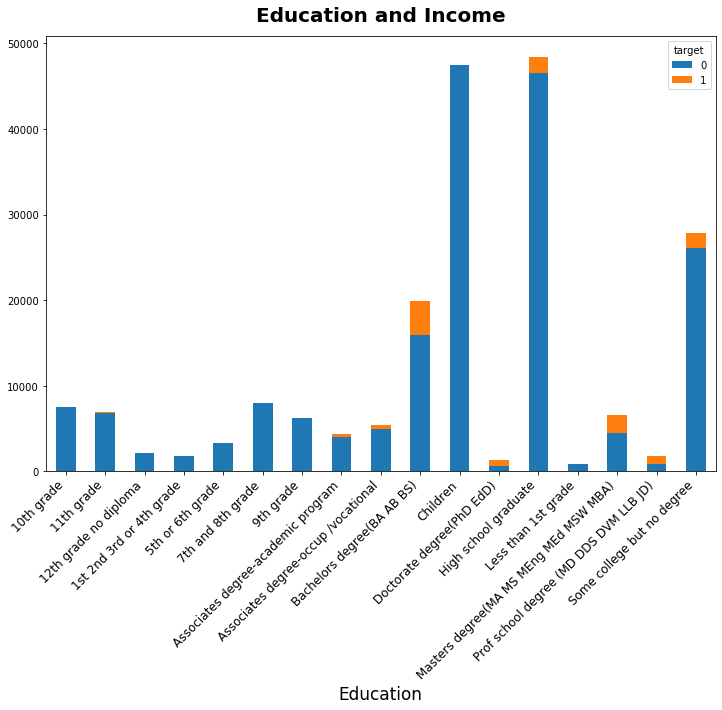

In [13]:
stacked_barchart(df, 'education')

## Marital Status
Those who are married living with their spouse have the greatest number of those making above $50000

### Figure 3.2

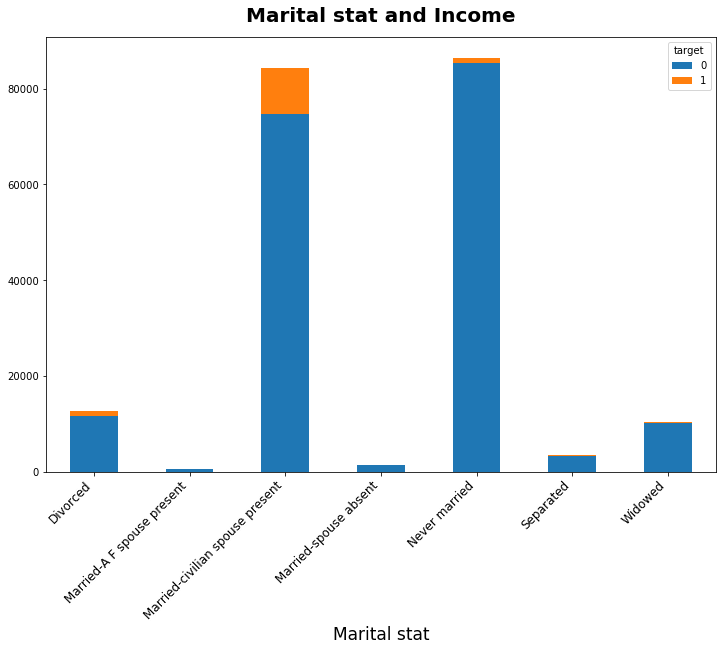

In [14]:
stacked_barchart(df, 'marital stat')

## Occupation
This may not be very conclusive after all as this question did not apply to most respondents. Executives, professionals and those in Sales do make more money however.

### Figure 3.3

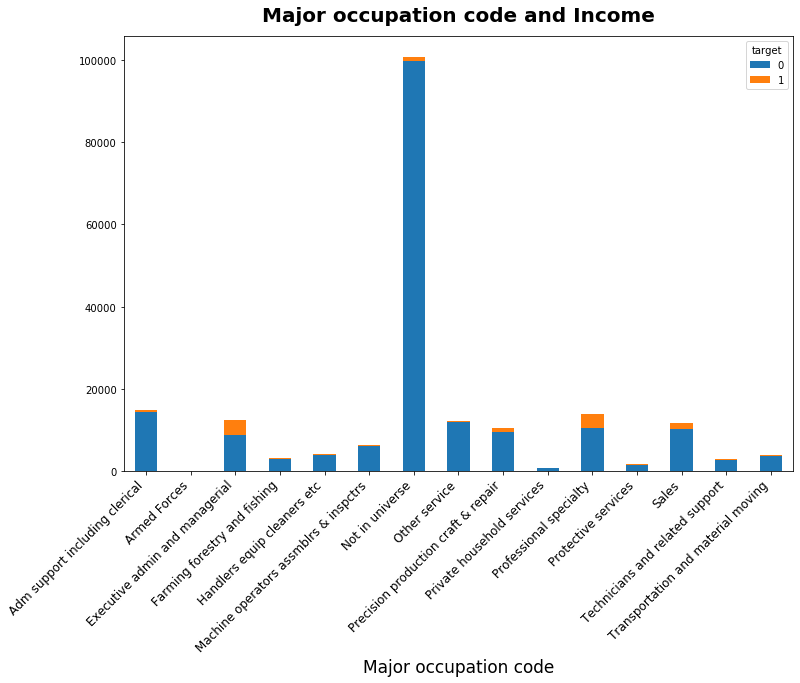

In [15]:
stacked_barchart(df, 'major occupation code')

## Age
Since age is continuous, I will bin the data in the column to make it easier to visualize (I do this for weeks worked and stock related fields as well). For now, I make a copy of the training data because I'm not sure if I will use the binned data.

It's clear that it's harder to have an income over $50000 when you are very young or old. This makes sense because young people may not be working yet or have low paying jobs and older people may be retired.

In [16]:
df_copy = df.copy()
test_copy = test.copy()

age_groups = ['-18', '18-24', '25-34', '35-44', '45-54', '55-65', '65+']
cut_bins = [min(df_copy.age)-1, 18, 25, 35, 45, 55, 65, max(df_copy.age)+1]
df_copy['age_groups'] = pd.cut(df_copy.age, bins=cut_bins, labels=age_groups)

### Figure 3.4

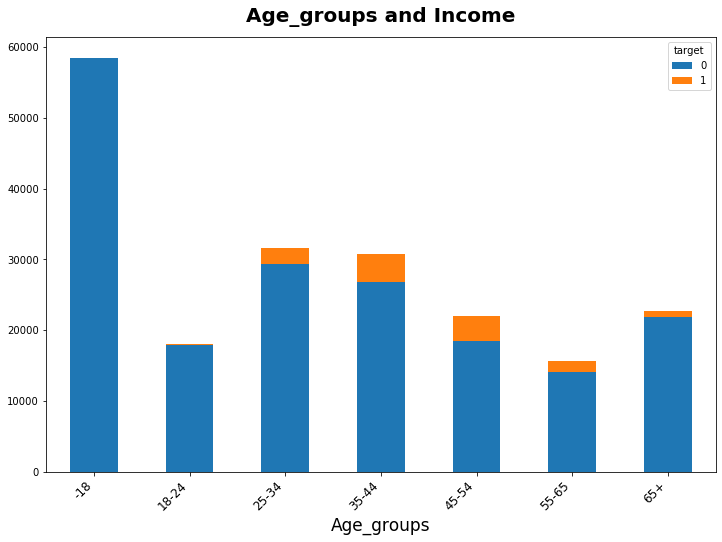

In [17]:
stacked_barchart(df_copy, 'age_groups')

## Weeks worked in the year
It is not surprising that the largest amount of people making over $50000 also tend to work the most. I am surprised by how many people do not work much (zero to 10 weeks per year), as well as how u-shaped this grouping is (I though there would be more people in the middle groups, I guess American's work a lot).

In [18]:
week_groups = ['Little to None', 'Below Average', 'Average',  'Most of Year']

cut_bins = [min(df_copy['weeks worked in year'])-1, 10, 35, 46, max(df_copy['weeks worked in year'])+1]
df_copy['week_groups'] = pd.cut(df_copy['weeks worked in year'], bins=cut_bins, labels=week_groups)

### Figure 3.5

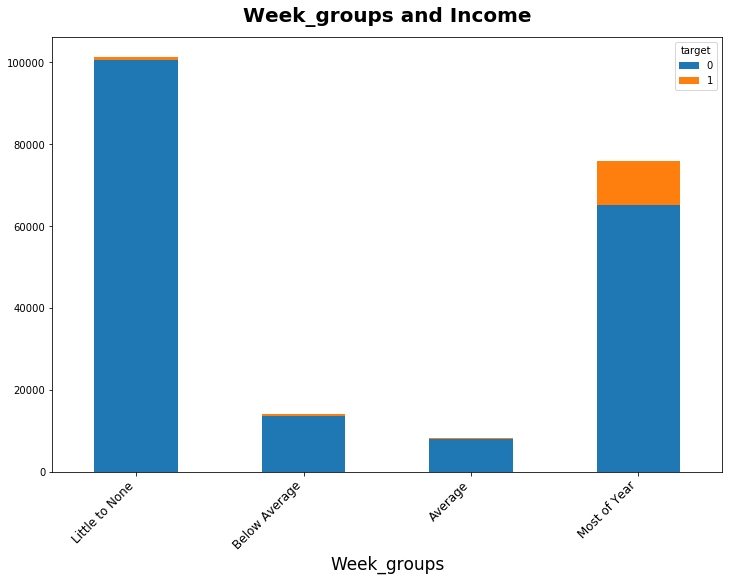

In [19]:
stacked_barchart(df_copy, 'week_groups')

## Stock related fields: capital gains, capital losses and dividends from stocks
I will lump all of these into one field: net earnings, then bin them (similarly to age). It's interesting to see that the frequency of of those earning above $50000 is the same in both groups, but there is a much larger percentage in the positive gains group. 

In [20]:
df_copy['net_stock_earnings'] = df_copy['capital gains'] - df_copy['capital losses'] + df_copy['dividends from stocks']
test_copy['net_stock_earnings'] = test_copy['capital gains'] - test_copy['capital losses'] + test_copy['dividends from stocks']

gains_groups = ['Loss or Nothing', 'Gains']
cut_bins = [min(df_copy['net_stock_earnings'])-1, 0, max(df_copy['net_stock_earnings'])+1]
df_copy['gains_groups'] = pd.cut(df_copy['net_stock_earnings'], bins=cut_bins, labels=gains_groups)

### Figure 3.6

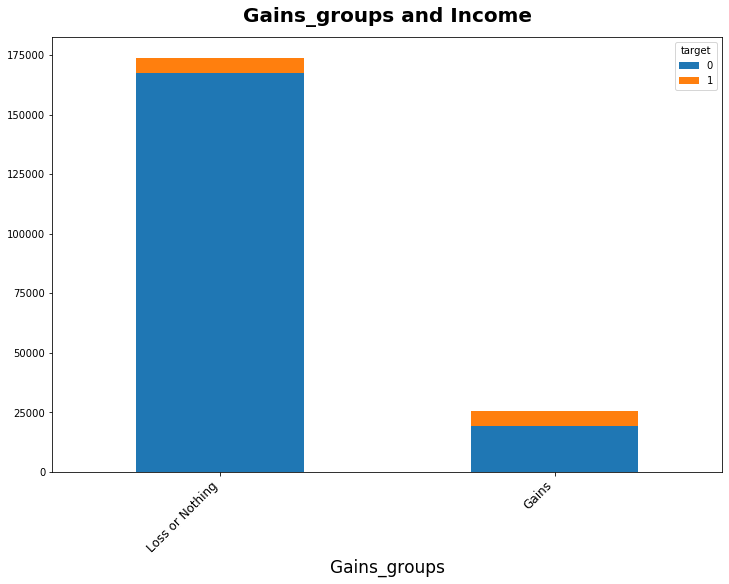

In [21]:
stacked_barchart(df_copy, 'gains_groups')

# Feature engineering
Since there are a lot of categorical features (nominal ones) I will LabelEncode the categorical columns and stick to decision tree models for now since they can handle categorical (or label encoded data) well, as opposed to a logistric model which would get thrown off by the fact that the features are not ordinal. I'm choosing to do this because many of the features have high cardinality, therefore one-hot-encoding them for the purpose of modeling makes decision trees impractical (especially random forest) because the data will be quite sparse (many 0s, few 1s). If the results from the decision tree models are not good, and if I have time, I will try one-hot-encoding the categorical data in hopes of improving the results.

In [22]:
def encode_categories(training, testing):
    '''Given the training data and test data, encodes the categorical columns of the dataframes.
       fits to and transforms the training data, transforms the test data.
       Input: training and test sets
       Output: Same dataframes but with categorical variables encoded.'''
    
    training['test or train'] = 0
    testing['test or train'] = 1
    
    full_df = pd.concat([training, testing])
    full_df.reset_index(inplace=True)
    
    full_df_encoded = full_df.select_dtypes(['category']).apply(LabelEncoder().fit_transform)
    
    full_df_encoded = full_df_encoded.join(full_df[full_df.columns[full_df.dtypes == 'int64']])
    
    df_encoded = full_df_encoded[full_df_encoded['test or train'] == 0]
    test_encoded = full_df_encoded[full_df_encoded['test or train'] == 1]
    
    return df_encoded.drop('test or train', axis=1), test_encoded.drop('test or train', axis=1)

In [23]:
df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('category'))
test[test.select_dtypes(['object']).columns] = test.select_dtypes(['object']).apply(lambda x: x.astype('category'))

df_encoded, test_encoded = encode_categories(df, test)

# Modeling with Decision Trees

Because of the way I encoded the categorical data, I am going to use tree models, which tend to handle this type of data better because they are not parameter based. For now I am not using cross validation since it's not so important for a random forest model, for example, and I am not expecting the decision tree to outperform the random forest model.

In [24]:
def scoreModel(X, y, model, random_state):
    
    '''Takes in dataframe features and target, splits the data into train and val, then fits the model and
    returns the various scores of the model.
    
    input:
            X: Features from DataFrame
            y: Target from DataFrame
            models: dictionary of models to score
    output: accuracy, precision, recall, f1 and ROC AUC of models'''
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=random_state)
    
    columns = ['dummy', 'accuracy', 'precision', 'recall', 'f1', 'ROC AUC']
    
    model.fit(X_train, y_train)
    pred = model.predict(X_val)

    scores = [1-y_val.mean(), accuracy_score(y_val, pred), precision_score(y_val, pred), recall_score(y_val, pred),
             f1_score(y_val, pred), roc_auc_score(y_val, model.predict_proba(X_val)[:,1])]

    row_dict = dict(zip(columns, scores))
        
    return row_dict

In [25]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=0)
rfc = RandomForestClassifier(class_weight='balanced', random_state=0)
gb = GradientBoostingClassifier(random_state=0)

### Decision Tree

In [26]:
dt_scores = scoreModel(df_encoded.drop('target', axis=1), df_encoded.target, dt, 42)
dt_scores


{'dummy': 0.940678815581083,
 'accuracy': 0.9350654557847677,
 'precision': 0.4513888888888889,
 'recall': 0.43933761405880367,
 'f1': 0.4452817263230005,
 'ROC AUC': 0.7028323550452579}

### Random Forest

In [27]:
rf_scores = scoreModel(df_encoded.drop('target', axis=1), df_encoded.target, rfc, 42)
rf_scores


{'dummy': 0.940678815581083,
 'accuracy': 0.9553737896192939,
 'precision': 0.7488119484046164,
 'recall': 0.3727610679283542,
 'f1': 0.4977436823104693,
 'ROC AUC': 0.9408863579068375}

### Gradient Boosting

In [28]:
gb_scores = scoreModel(df_encoded.drop('target', axis=1), df_encoded.target, gb, 42)
gb_scores

{'dummy': 0.940678815581083,
 'accuracy': 0.9565165092921152,
 'precision': 0.7447335811648079,
 'recall': 0.40621831699898614,
 'f1': 0.5256942925869232,
 'ROC AUC': 0.9491496094004503}

## Summary of results
The higher ROC AUC scores, with the lower f1 scores, indicate that the models (especially random forest and gradient boosting) have the potential to improve with some threshold adjustment. 

## Question as to which metric to use
It's hard to know which metric is best to use in this case because there is no known research question for this project. I just know that I'm trying to predict whether someone will make above or below $50000 and find which features are most important for this. I do not know, however, what will be done with this prediction.

Accuracy is no doubt a poor metric to use on its own becuase of the class imbalance (approximately 93 to 7), although a one percent improvement on the dummy classifier in this case is not so bad.

If I was trying to identify who needs to be taxed more based on their census responses (those who make more money should be taxed more) then I would argue the need to prioritize precision. In this case precision is (# correct predictions above 50000 ) / (# of predictions above 50000). In other words: how precise are we in predicting the case when someone makes over 50000? I think this is more important for the purposes of taxation because we do not want to be taxing people more who do not deserve to be taxed. Lower recall is okay in this case, because taxing people who don't deserve it is worse than not taxing people who do (in my opinion). 

At the moment I cannot think of a scenerio in this case where prioritizing recall makes more sense. For the purpose of this investigation, I will look to optimize f1, since this balances precision and recall.

# Feature Importance

The most direct way to identify the feature importance is by just using the method `feature_importances_` (as I've used in the function below). I want to return the features in their own dataframe and also a subset of the original dataframe containing only the most important features (possibly for fitting models again later).

In [31]:
def top_features(model, data, target, k=10):
    '''Given a model, features, target and desired number of top features, returns the best features of dataset
    determined by a given model.
    Input: 
        Model: the desired model
        X: features
        y: target
        n: the desired number of features (default is 10)
    Output: Returns a DataFrame containing the best features of the dataset and a new DataFrame
        using only the top features determined (can be used for fitting once again).'''
    
    X_train, X_val, y_train, y_val = train_test_split(data, target, test_size = 0.25, random_state=42)
    model = model.fit(X_train, y_train)
    
    feature_scores = pd.DataFrame(model.feature_importances_)
    dfcolumns = pd.DataFrame(data.columns)
    featureScores = pd.concat([dfcolumns,feature_scores],axis=1)
    featureScores.columns = ['Feature','Importance']
    
    best_feature_df = data.loc[:, featureScores.nlargest(k,'Importance')['Feature'].values]
    
    return featureScores.nlargest(k,'Importance'), best_feature_df

In [32]:
def plotFeatureImportance(feature_df):
    '''Given a DataFrame of feature importances, plots a bar chart of the importance
       of each feature relative to the most important feature.
       Input: dataframe of feature importances
       Output: Horizontal bar chart showing the importances relative to the most 
               important feature.'''
    
    feature_df.set_index('Feature', inplace=True)
    
    fig, ax = plt.subplots(figsize=(10,6))

    top_feature = feature_df.index[0].capitalize()

    plt.title('Feature Importance Relative to Top Feature: {}'.format(top_feature), fontsize=20, fontweight='bold', pad=15)
    plt.xlabel('Relative Importance', fontsize=15, labelpad=7)
    plt.ylabel('Feature', fontsize=15)

    sorted_features = feature_df.Importance.sort_values()
    sorted_features.div(feature_df.Importance.max(), axis=0).multiply(100).plot(kind='barh');


## Random Forest Feature Importance

In [33]:
rf_top_features, rf_top_features_df = top_features(rfc, df_encoded.drop('target', axis=1), df_encoded.target, k=10)

### Figure 6.1

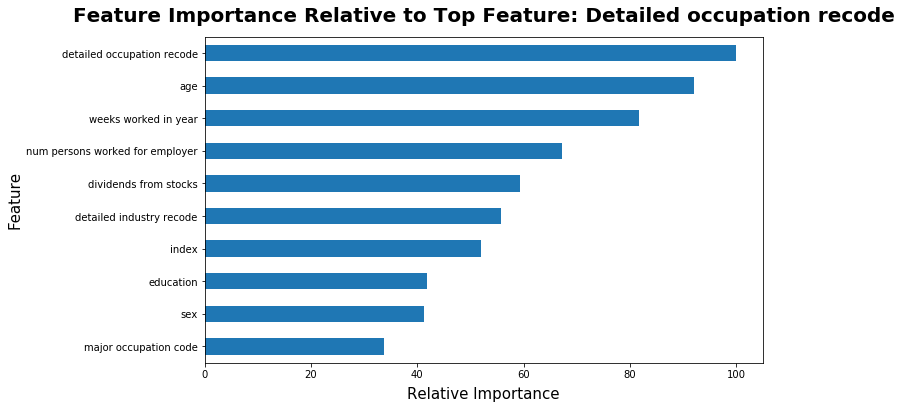

In [34]:
plotFeatureImportance(rf_top_features)

## Gradient Boosting Feature Importance

In [57]:
gb_top_features, gb_top_features_df = top_features(gb, df_encoded.drop('target', axis=1), df_encoded.target, k=10)

### Figure 6.1

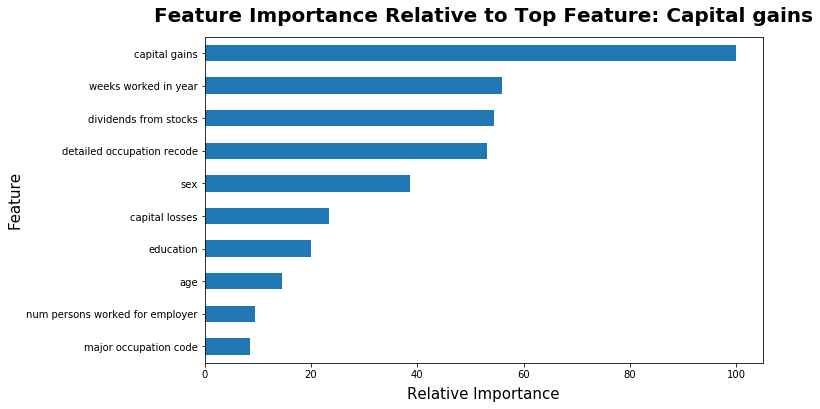

In [36]:
plotFeatureImportance(gb_top_features)

## Refit models using the best features
Both sets of results are quite similar to using the entire feature space, but the speed of the performance was about the same. I will keep all the features since they seem to yield slight better results.

In [37]:
rf_scores_top_features = scoreModel(rf_top_features_df, df_encoded.target, rfc, 42)
rf_scores_top_features

{'dummy': 0.940678815581083,
 'accuracy': 0.9505422906517512,
 'precision': 0.6572890025575447,
 'recall': 0.34741466711726937,
 'f1': 0.45456555383594954,
 'ROC AUC': 0.9212531517255294}

In [38]:
gb_scores_top_features = scoreModel(gb_top_features_df, df_encoded.target, gb, 42)
gb_scores_top_features

{'dummy': 0.940678815581083,
 'accuracy': 0.9569174635632806,
 'precision': 0.749384236453202,
 'recall': 0.4112875971612031,
 'f1': 0.5310931704123937,
 'ROC AUC': 0.9469216052024759}

# Threshold adjustment and model selection
As I said before, a high ROC AUC score and low f1 shows that there is potential to improve the model by adjusting the thresholds for which they make decisions on how to classify a particular row. This is less computationally intense than paramter tuning and takes far less time. I wrote the function below to identify the best threshold for a particular classifiction model.

In [39]:
def optimalThreshold(model, X, y, metric, random_state):
    '''Given a model, features, target and metric, returns the threshold
       which optimizes the given metric.
       Input: model, features, target, metric, random state
       Ouput: optimal threshold'''

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=random_state)
    
    model.fit(X_train, y_train)
    thresh_ps = np.linspace(.10,.90,1000)
    model_val_probs = model.predict_proba(X_val)[:,1]
    
    scores = []
    
    for p in thresh_ps:
        model_val_labels = model_val_probs >= p
        scores.append(metric(y_val, model_val_labels)) 

    best_score = np.max(scores) 
    best_thresh_p = thresh_ps[np.argmax(scores)]
    
    print('Best {} score %.3f at prob decision threshold >= %.3f'.format(metric.__name__.split('_')[0])
          % (best_score, best_thresh_p))
    
    return best_score, best_thresh_p
 

In [40]:
best_rf_score, best_rf_p = optimalThreshold(rfc, df_encoded.drop('target', axis=1), df_encoded.target, f1_score, 42)

Best f1 score 0.589 at prob decision threshold >= 0.251


In [41]:
best_gb_score, best_gb_p = optimalThreshold(gb, df_encoded.drop('target', axis=1), df_encoded.target, f1_score, 42)

Best f1 score 0.593 at prob decision threshold >= 0.301


## Confusion Matrix
The function below uses the optimal thresholds previously calculated and returns a confusion matrix of the results. I wanted to use this because it makes the interpretation of precision, recall etc, a bit more user friendly and gives a better sense of model performance.

In [42]:
def make_confusion_matrix(X, y, model, threshold, random_state):
    '''Given a model, features, target and threshold, returns the confusion matrix,
       as well as all the calculated scores (accuracy, recall, precision, f1)
       Input: model, features, target, threshold, random state
       Output: scores mentioned above and confusion matrix'''
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=random_state)
    
    model.fit(X_train, y_train)
    
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    
    print('F1 score:', f1_score(y_val, y_predict))
    print('Precision Score:', precision_score(y_val, y_predict))
    print('Recall Score:', recall_score(y_val, y_predict))
    print('Accuracy Score:', accuracy_score(y_val, y_predict))
          
    income_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(income_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=["Below 50000", 'Above 50000'],
           yticklabels=["Below 50000", 'Above 50000']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

F1 score: 0.5891975308641976
Precision Score: 0.5421755183186595
Recall Score: 0.6451503886448124
Accuracy Score: 0.9466329865078887


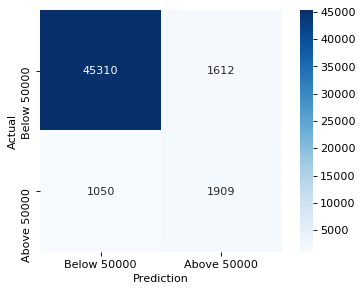

In [43]:
make_confusion_matrix(df_encoded.drop('target', axis=1), df_encoded.target, rfc, best_rf_p, 42)

F1 score: 0.5929097448193185
Precision Score: 0.6010416666666667
Recall Score: 0.5849949307198378
Accuracy Score: 0.9523465848719953


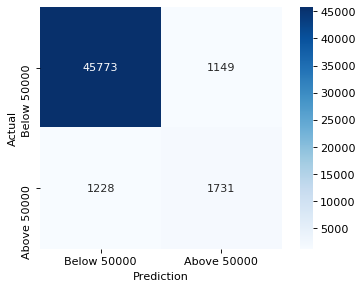

In [45]:
make_confusion_matrix(df_encoded.drop('target', axis=1), df_encoded.target, gb, best_gb_p, 42)

On this particular split gradient boosting does slightly better. I will use this for my final model.

# Final Test 

The function below displays the results on the test set in the form of a confusion matrix

In [46]:
def testModel(model, X_train, X_test, y_train, y_test, threshold):
    '''Given a model, features, target and threshold, returns the confusion matrix,
       as well as all the calculated scores (accuracy, recall, precision, f1)
       Input: model, features, target, threshold, random state
       Output: scores mentioned above and confusion matrix'''
    
    model.fit(X_train, y_train)
    
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    
    print('F1 score:', f1_score(y_test, y_predict))
    print('Precision Score:', precision_score(y_test, y_predict))
    print('Recall Score:', recall_score(y_test, y_predict))
    print('Accuracy Score:', accuracy_score(y_test, y_predict))
          
    income_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(income_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=["Below 50000", 'Above 50000'],
           yticklabels=["Below 50000", 'Above 50000']);
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

F1 score: 0.5981416957026714
Precision Score: 0.6143490115882754
Recall Score: 0.5827675396055609
Accuracy Score: 0.9514444377618733


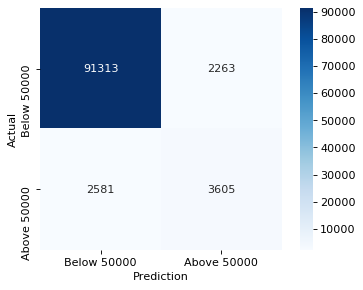

In [47]:
testModel(gb, df_encoded.drop('target', axis=1), test_encoded.drop('target', axis=1), df_encoded.target,
          test_encoded.target, best_gb_p)

In [49]:
test_encoded.target.value_counts(normalize=True)

0    0.937992
1    0.062008
Name: target, dtype: float64

# Summary of results and conclusion

## Model performance

These results indicate that the model may be slightly overfitting, but is overall doing well since most of the scores are similar (if not a bit better) than what was achieved on the validation sets. A way to potentially improve results  would be to do a robust GridsearchCV to find a more optimal set of parameters (as opposed to just adjusting the threshold). One problem with Gradient Boosting is that it has a lot of parameters to tune, in which case a Random Forest model may be preferable because there are fewer parameters to worry about.

Additionally I could have tried more creative feature engineering (interaction terms), but I think this detracts from the interpretability of the features.

## Important Features

The features shown below (figure 9.1) are the most impactful for predicting whether or not someone will make above $50000. It's not a surprise that capital gains, weeks worked (see figure 3.5 above), stock dividends and occupation are strong predictors of income level.  This seems to suggest that if you work a lot, have a certain occupation (executive, sales, professional as seen before in figure 3.3) then you will make more money. Therefore you can perhaps make even more money from the stock market. 

I anticipated that some of the remaining features would also be strong predictors, like capital losses, age, education and again occupation (major occupation code). It's also not a surprise that these appear since younger and older people do not make as much money as middle aged people (see figure 3.4) but also men unfortunately tend to make more money than women in the United States (see figure 9.2 below).

In summary, the general profile for someone who makes above $50000 is a person who is likely active in the stock market, they tend to work more, they are a middle aged man and educated.

### Figure 9.1

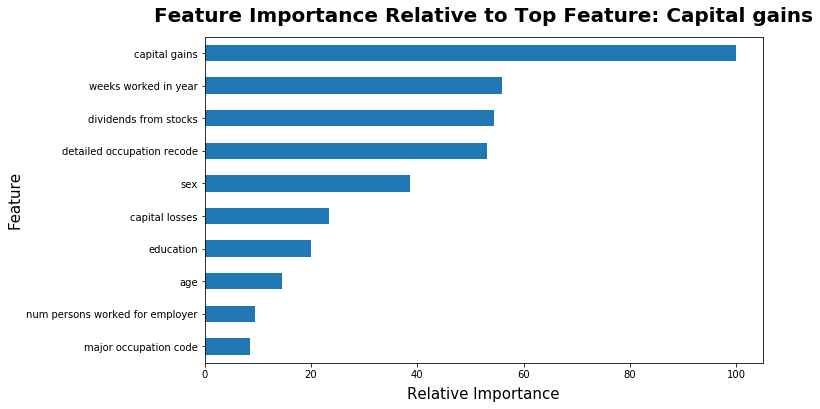

In [58]:
plotFeatureImportance(gb_top_features)

### Figure 9.2

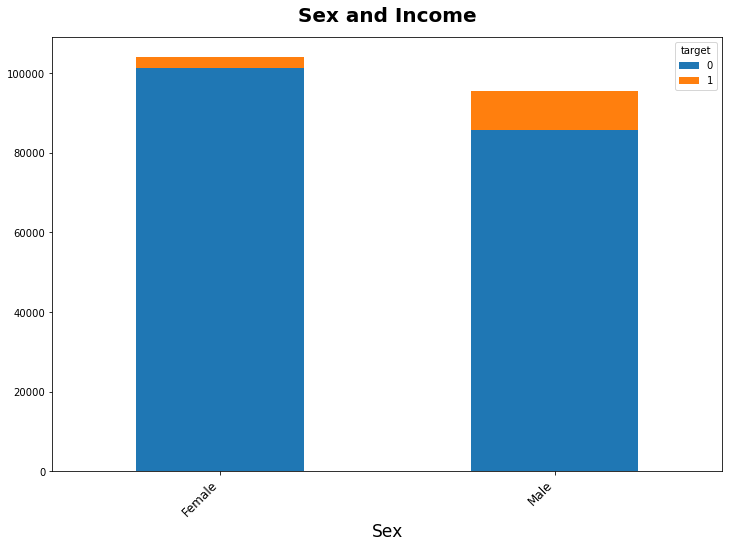

In [59]:
stacked_barchart(df_copy, 'sex')

# Reflection

## Things that surprised me or did not yield better results than the method I chose
During this assignment I was caught off guard a few times after trying some techniques which I though would give betters results than they did. Those are as follows:

**1. Using Oversampling/SMOTE to handle the class imbalance**

These not only failed to improve the model, they actually made the results much worse on the validation sets. I had success with these techniques in the past, so I was surprised to see this. Including the `class_weights=balanced` paramter helped the random forest model however. My guess as to why oversampling did not help is because of added noise due to the additional data.

To see my code for this (no results shown) please see the appendix below.

**2. Removing "redudent features" did not improve the models.**

While getting a feel for the data and during the eda, I noticed some of the features were very similar (such as **detailed industry recode** and **major industry code**. I thought that removing one of these would improve the results on the validation sets, but it did not.

**3. Binning the numerical data and reducing the cardinality of some features did not help**

After my initial analysis I did an extensize amount of feature engineering thinking this would help improve the results of the models. I tried binning the continuous data, and for columns with many unique entries, I tried grouping certain ones together (for example, I made the country of birth columns binary: US or Abroad). My thinking here was that nominal data with high cardinality would cause problems but it seems that the models prefered having the original feature space in its entirety as opposed to an altered and reduced form.

To see my code for this please see the appendix below.

**4. OneHotEncoding all the categorical features (including the numerical groups I made)**

I fit a logistic model to this dataset which ended up having 213 features, I also tried fitting some support vector machines to the OneHotEncoded data (these ended up taking too long to fit). The logistic model did not give better results on the validation set compared to the Gradient Boosting model (or the Random Forest model) that I chose.

To see my code for this please see the appendix below.

## Appendix - things I tried but did not work out so well

### Function which fits a model using oversampled ata

In [60]:
def score_MODEL_oversample(X, y, model, random_state):
    
    '''Takes in dataframe features and target, splits the data into train and val, then fits the model and
    returns the various scores of the model.
    
    input:
            X: Features from DataFrame
            y: Target from DataFrame
            models: dictionary of models to score
    output: accuracy, precision, recall, f1 and ROC AUC of models'''
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state=random_state)
    
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X_train, y_train)
    
    columns = ['dummy', 'accuracy', 'precision', 'recall', 'f1', 'ROC AUC']
    df = pd.DataFrame(columns=columns)
    
    model.fit(X_res, y_res)
    pred = model.predict(X_val)

    scores = [1-y_val.mean(), accuracy_score(y_val, pred), precision_score(y_val, pred), recall_score(y_val, pred),
             f1_score(y_val, pred), roc_auc_score(y_val, model.predict_proba(X_val)[:,1])]

    row_dict = dict(zip(columns, scores))
        
    return row_dict

### Grouping more numerical data and reducing cardinality of categorial data

#### Grouping more numerical fields (in addition to those grouped in the eda)

In [ ]:
wage_groups = ['Non-hourly wage', 'Below Min Wage', 'Below Living Wage', 'Living Wage', 'Above Living Wage', 
                'High Hourly Wage']
cut_bins = [-0.01, 0.01, 800, 1500, 2500, 5000, max(df['wage per hour'])]
df['wage_groups'] = pd.cut(df['wage per hour'], bins=cut_bins, labels=wage_groups)

cut_bins = [-0.01, 0.01, 800, 1500, 2500, 5000, max(test['wage per hour'])]
test['wage_groups'] = pd.cut(test['wage per hour'], bins=cut_bins, labels=wage_groups)

In [ ]:
week_groups = ['Little to None', 'Below Average', 'Average',  'Most of Year']

cut_bins = [min(df['weeks worked in year'])-1, 10, 35, 46, max(df['weeks worked in year'])+1]
df['week_groups'] = pd.cut(df['weeks worked in year'], bins=cut_bins, labels=week_groups)

cut_bins = [min(test['weeks worked in year'])-1, 10, 35, 46, max(test['weeks worked in year'])+1]
test['week_groups'] = pd.cut(test['weeks worked in year'], bins=cut_bins, labels=week_groups)

In [ ]:
df.drop(['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 
              'weeks worked in year', 'net_stock_earnings'], axis=1, inplace=True)

test.drop(['age', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks', 
              'weeks worked in year', 'net_stock_earnings'], axis=1, inplace=True)

#### Reducing cardinality of categorial data

In [ ]:
education_groups = ['HS grad', 'Some college', 'No HS', 'Child', 'Bachelors degree', 'Advanced degree',
                   'No HS', 'Associates degree', 'No HS', 'No HS', 'Associates degree', 'Advanced degree',
                   'No HS', 'No HS', 'Advanced degree', 'No HS', 'No HS']

edu_dict = dict(zip(df.education.unique(), education_groups))

df.education.replace(edu_dict, inplace=True)
test.education.replace(edu_dict, inplace=True)

In [ ]:
race_groups = ['White', 'Non-White', 'Non-White', 'Non-White', 'Non-White']

race_dict = dict(zip(df.race.unique(), race_groups))

df.race.replace(race_dict, inplace=True)
test.race.replace(race_dict, inplace=True)

In [ ]:
mask = df['country of birth father'] == 'United-States'
mask2 = df['country of birth mother'] == 'United-States'
mask3 = df['country of birth self'] == 'United-States'

mask4 = test['country of birth father'] == 'United-States'
mask5 = test['country of birth mother'] == 'United-States'
mask6 = test['country of birth self'] == 'United-States'


df['country of birth father'] = df['country of birth father'].where(mask, 'Abroad')
test['country of birth father'] = test['country of birth father'].where(mask4, 'Abroad')

df['country of birth mother'] = df['country of birth mother'].where(mask2, 'Abroad')
test['country of birth mother'] = test['country of birth mother'].where(mask5, 'Abroad')

df['country of birth self'] = df['country of birth self'].where(mask3, 'Abroad')
test['country of birth self'] = test['country of birth self'].where(mask6, 'Abroad')

In [ ]:
moved_mask1 = df['state of previous residence'] == 'Not in universe'
moved_mask2 = test['state of previous residence'] == 'Not in universe'

df['state of previous residence'] = df['state of previous residence'].where(moved_mask1, 'Moved')
test['state of previous residence'] = test['state of previous residence'].where(moved_mask2, 'Moved')

In [ ]:
cols_to_drop = ['detailed industry recode', 'detailed occupation recode', 'education',
                'region of previous residence', 'instance weight', "fill inc questionnaire for veteran's admin", 
                'veterans benefits', 'year']

df.drop(cols_to_drop, axis=1, inplace=True)
test.drop(cols_to_drop, axis=1, inplace=True)

### Function to one hot encode all the categorical features

In [61]:
def oneHotEncodeCategories(training, testing):
    '''Given the training data and test data, encodes the categorical columns of the dataframes.
       fits to and transforms the training data, transforms the test data.
       Input: training and test sets
       Output: Same dataframes but with categorical variables encoded.'''
    
    training['test or train'] = 0
    testing['test or train'] = 1
    
    full_df = pd.concat([training, testing])
    full_df.reset_index(inplace=True)
    
    full_df_encoded = pd.get_dummies(full_df)

    df_encoded = full_df_encoded[full_df_encoded['test or train'] == 0]
    test_encoded = full_df_encoded[full_df_encoded['test or train'] == 1]
    
    return df_encoded.drop(['index', 'test or train'], axis=1), test_encoded.drop(['index', 'test or train'], axis=1)

In [ ]:
df_dummy, test_dummy = oneHotEncodeCategories(df, test)